### Climate skill at 1&deg;: annual- and global-mean time series

In [1]:
from collections import namedtuple
from string import ascii_lowercase

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import get_beaker_dataset_variables, savefig, DPI, FONTSIZE
from constants import INFERENCE_COMPARISON_1DEG

In [2]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter air temperature", "K"),
    EvalVar("total_water_path", "total water path", "mm"),
]
ADDITIONAL_VARS = ['surface_temperature']
DS_VARS = [var.name for var in EVAL_VARS] + ADDITIONAL_VARS

In [3]:
# download annual- and global-mean time series from beaker

datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        for ic_name, ic_run in group_runs.items():
            if "-" in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([duration_name, group_name, ic_name])
            print(f"Getting run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'annual_diagnostics.nc', DS_VARS)
            dims = {'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]}
            datasets.append(
                ic_dataset
                .expand_dims(**dims)
            )
annual_mean_ds = xr.merge(datasets).squeeze()

Downloading ⠧ 0:00:00 1.4 MB/s 122.9 kB

In [4]:
# # download monthly data for forced SST time series from beaker
# !beaker dataset fetch "01J70F1FBDCR6WGNCYRD997JFB" --prefix "monthly_mean_target.nc" --output "./data/"

# compute forced SST time series excluding high latitudes
monthly_target = xr.open_dataset('./data/monthly_mean_target.nc', chunks={}, engine='h5netcdf').squeeze()
weights = np.cos(np.deg2rad(monthly_target.lat))
forced_sst = monthly_target.surface_temperature.where(monthly_target.ocean_fraction > 0.5).where(np.fabs(monthly_target.lat) < 45)
forced_sst_annual_mean = forced_sst.groupby(forced_sst.valid_time.dt.year).mean()
forced_sst_annual_global_mean = forced_sst_annual_mean.weighted(weights).mean(dim=['lat', 'lon']).compute()

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 4))
plt.rc('ytick', labelsize=(FONTSIZE - 4))
plt.rc('figure', dpi=DPI)

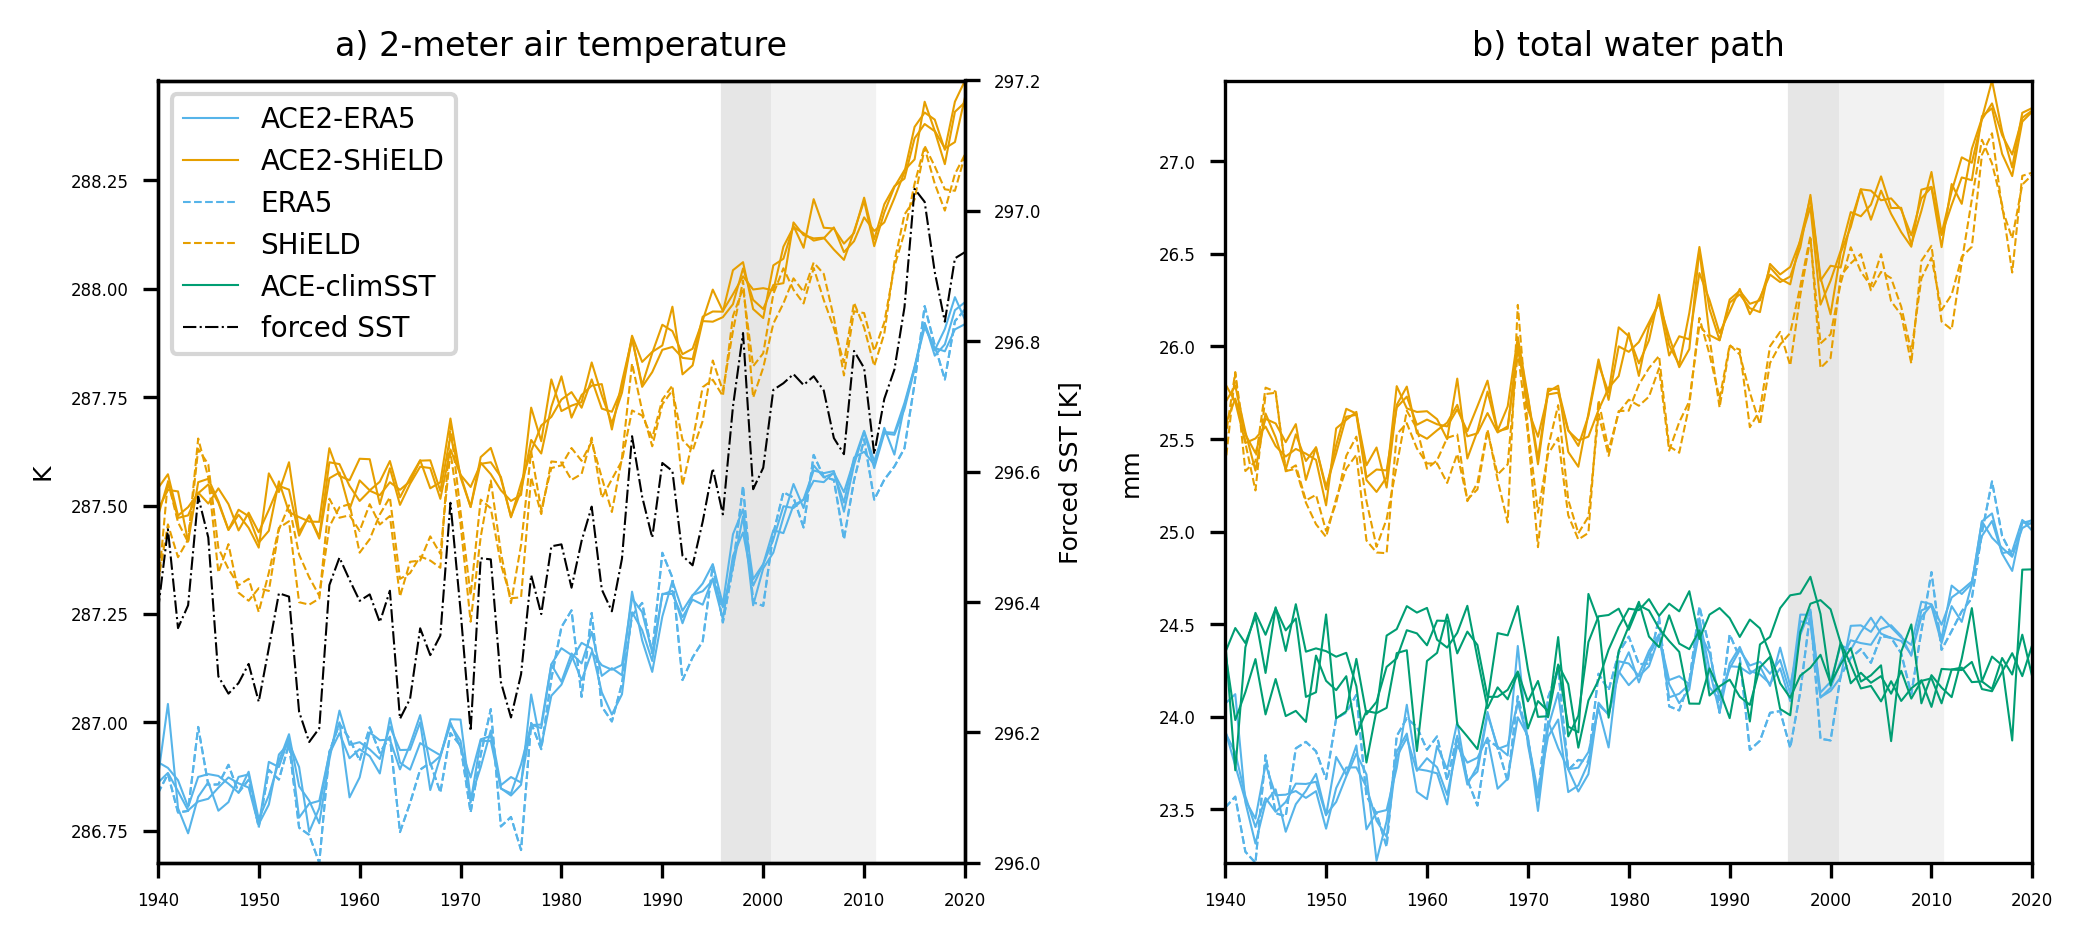

In [9]:
holdout_period1 = [1996, 2001]
fillcolor1 = [0.9, 0.9, 0.9]
holdout_period2 = [2001, 2011]
fillcolor2 = [0.95, 0.95, 0.95]
figsize = [1.27 * dim for dim in [5.5, 2.5]] # should be [5.5, 2.5], but need to scale up for unknown font size reasons

fig, axes = plt.subplots(1, len(EVAL_VARS), sharex='row', sharey='col', figsize=figsize)
axes = axes.squeeze()
for ax, var, letter in zip(axes, EVAL_VARS, ascii_lowercase):
    # highlight held-out periods
    ymin, ymax = annual_mean_ds[var.name].min(), annual_mean_ds[var.name].max()
    ax.fill_between(holdout_period1, [ymin, ymin], [ymax, ymax], color=fillcolor1)
    ax.fill_between(holdout_period2, [ymin, ymin], [ymax, ymax], color=fillcolor2)
    # time series
    hae = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE2-ERA5')[var.name].plot(
        ax=ax, hue='IC', lw=0.5, color=colors[0], add_legend=False
    )
    has = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE2-SHiELD')[var.name].plot(
        ax=ax, hue='IC', lw=0.5, color=colors[1], add_legend=False
    )
    he = annual_mean_ds.sel(source='target', duration='81yr', group='SHiELD-vs.-ERA5')[var.name].plot(
        ax=ax, hue='IC', lw=0.5, color=colors[0], ls='--', add_legend=False
    )
    ha = annual_mean_ds.sel(source='prediction', duration='81yr', group='SHiELD-vs.-ERA5')[var.name].plot(
        ax=ax, hue='IC', lw=0.5, color=colors[1], ls='--', add_legend=False
    )
    hc = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE-climSST')[var.name].plot(
        ax=ax, hue='IC', lw=0.5, color=colors[2], add_legend=False
    )
    if ax == axes[0]:
        ax2 = ax.twinx()
        hs = forced_sst_annual_global_mean.plot(ax=ax2, color='k', ls='-.', lw=0.5, label='forced SST', add_legend=False)
        ax2.set_ylabel('Forced SST [K]')
        ax2.set_ylim([296.0, 297.2])
        ax2.set_title(None)
        ax.legend(
            [hae[0], has[0], he[0], ha[0], hc[0], hs[0]],
            ['ACE2-ERA5', 'ACE2-SHiELD', 'ERA5', 'SHiELD', 'ACE-climSST', 'forced SST'],
            fontsize='small'
        )
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([1940, 2020])
    ax.set_ylabel(var.units)
    ax.set_xlabel(None)
    ax.set_title(f"{letter}) {var.long_name}")
fig.tight_layout()
savefig(fig, 'climate_skill_1deg_annual_mean_series.png')